# Consulta à API da SeFaz-SP

1) Consulta as informações de execução financeira e orçamentária da Secretaria da Fazenda e Planejamento do Estado de São Paulo, através da API pública, com uso de requests.

2) As informações de interesse, em formato XML, são extraídas com a bibliotaca Beautiful Soup.

3) Na sequência, usa-se o Pandas para a criação do DataFrame e gravação dos dados em arquivo csv.


In [1]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup

dados_despesas = []
orgaos = ['27000', '03000', '42000'] # 27000 - MPSP | 03000 - TJSP | 42000 - DPSP
anos = [2018, 2022]

In [2]:
def consulta_api(orgao, ano):
    url = "https://webservices.fazenda.sp.gov.br/WSTransparencia/TransparenciaServico.asmx?op=ConsultarDespesas"

    headers = {'Content-Type': 'text/xml'}
    payload = f"""<?xml version=\"1.0\" encoding=\"utf-8\"?>\n
              <soap:Envelope xmlns:xsi=\
              "http://www.w3.org/2001/XMLSchema-instance\" \
              xmlns:xsd=\"http://www.w3.org/2001/XMLSchema\" \
              xmlns:soap=\"http://schemas.xmlsoap.org/soap/envelope/\">\n
              <soap:Body>\n
              <ConsultarDespesas xmlns=\"http://fazenda.sp.gov.br/wstransparencia\">\n
              <ano>{ano}</ano>\n
              <codigoOrgao>{orgao}</codigoOrgao>\n
              <codigoFonteRecursos>Detalhado</codigoFonteRecursos>\n
              <flagCredor>1</flagCredor>\n
              <flagEmpenhado>1</flagEmpenhado>\n
              <flagLiquidado>1</flagLiquidado>\n
              <flagPago>1</flagPago>\n
              </ConsultarDespesas>\n
              </soap:Body>\n
              </soap:Envelope>"""

    resposta = requests.request("POST", url, headers=headers, data=payload, verify=False)
    print(f"Ano: {ano}: Status: {resposta.status_code}")
    return resposta.text # unicode

In [3]:
def gera_lista(ano, despesas, dados_despesas):
    bs_despesas = BeautifulSoup(despesas)
    nome_orgao = bs_despesas.find_all('codigonomeorgao')
    fonte = bs_despesas.find_all('codigonomefonterecursos')
    tipo_licitacao = bs_despesas.find_all('codigonometipolicitacao')
    favorecido = bs_despesas.find_all('cgccpffavorecido')
    natureza = bs_despesas.find_all('naturezadespesanomeitem')
    empenhado = bs_despesas.find_all('valorempenhado')
    liquidado = bs_despesas.find_all('valorliquidado')
    pago = bs_despesas.find_all('valorpago')
    anos_anteriores = bs_despesas.find_all('valorpagoanosanteriores')
    for n in range(0,len(nome_orgao)):
        linhas = [ano, nome_orgao[n].get_text(), fonte[n].get_text(), tipo_licitacao[n].get_text(), 
                  favorecido[n].get_text(), natureza[n].get_text(), empenhado[n].get_text(), 
                  liquidado[n].get_text(), pago[n].get_text(), anos_anteriores[n].get_text()]
        dados_despesas.append(linhas)
    return dados_despesas

In [4]:
def converte_moeda (str_numero):
    """Converte valores monetários para float com duas casas decimais"""
    try:
        str_numero = str_numero.replace('.', '').replace(',', '.')
        resultado = round(float(str_numero), 2)
        return resultado
    except ValueError:
        return str_numero

In [5]:
import warnings
warnings.filterwarnings("ignore")
for orgao in orgaos:
    print(f"Verificando órgão: {orgao}")
    for ano in range (anos[0], anos[1]+1):
        despesas = consulta_api(orgao, str(ano))
        gera_lista(ano, despesas, dados_despesas)
    print()
warnings.resetwarnings()

Verificando órgão: 27000
Ano: 2018: Status: 200
Ano: 2019: Status: 200
Ano: 2020: Status: 200
Ano: 2021: Status: 200
Ano: 2022: Status: 200

Verificando órgão: 03000
Ano: 2018: Status: 200
Ano: 2019: Status: 200
Ano: 2020: Status: 200
Ano: 2021: Status: 200
Ano: 2022: Status: 200

Verificando órgão: 42000
Ano: 2018: Status: 200
Ano: 2019: Status: 200
Ano: 2020: Status: 200
Ano: 2021: Status: 200
Ano: 2022: Status: 200



In [6]:
# Criação do Dataframe
colunas = ['Ano', 'Órgão', 'Fonte de recursos', 'Tipo de licitação', 'Favorecido','Natureza',
           'Empenhado', 'Liquidado', 'Pago', 'Anos anteriores']

df_despesas = pd.DataFrame(dados_despesas, columns=colunas)

# Eliminação das linhas de totalização
df_despesas['Órgão'].replace('', np.nan, inplace=True)
df_despesas.dropna(subset = ['Órgão'], inplace=True)
df_despesas.sample(5)

,Ano,Órgão,Fonte de recursos,Tipo de licitação,Favorecido,Natureza,Empenhado,Liquidado,Pago,Anos anteriores
19080,2022,42000 - DEFENSORIA PUBLICA DO ESTADO,003 - RECURSOS VINCULADOS-FUNDO ESPECIAL DE DE...,9 - INDEPEND LICITACAO,23085669817 - MARIA CAROLINA DOMINGUES FRANCO,33909301 - INDENIZACOES E RESTITUICOES DIVERSAS,"563,76","563,76","563,76","0,00"
13891,2019,42000 - DEFENSORIA PUBLICA DO ESTADO,003 - RECURSOS VINCULADOS-FUNDO ESPECIAL DE DE...,9 - INDEPEND LICITACAO,31123558817 - CAROLINA ROMANI BRANCALION,33901401 - DIARIAS PESSOAL CIVIL,"1.335,88","1.335,88","1.335,88","0,00"
15502,2020,42000 - DEFENSORIA PUBLICA DO ESTADO,003 - RECURSOS VINCULADOS-FUNDO ESPECIAL DE DE...,5 - DISPENSA DE LICITACAO,26895519858 - CAROLINA MOREIRA GAMA,"33903625 - CURSOS, PALESTRAS","825,00","825,00","825,00","0,00"
16264,2021,42000 - DEFENSORIA PUBLICA DO ESTADO,002 - RECURSOS VINCULADOS ESTADUAIS,9 - INDEPEND LICITACAO,23510854853 - MARIA HELENA RAMOS BONONI,33903611 - OUTRAS REMUNERACOES DE SERVICOS PES...,"361,22","361,22","361,22","0,00"
2926,2021,27000 - MINISTERIO PUBLICO,001 - TESOURO-DOT.INICIAL E CRED.SUPLEMENTAR,7 - PREGÃO,27106398000100 - LC COMERCIAL EIRELI,"33903012 - MATERIAL DE CAMA, MESA E BANHO","0,00","0,00","0,00","4.272,00"


In [7]:
df_despesas['Empenhado'] = df_despesas['Empenhado'].apply(lambda x:converte_moeda(x))
df_despesas['Liquidado'] = df_despesas['Liquidado'].apply(lambda x:converte_moeda(x))
df_despesas['Pago'] = df_despesas['Pago'].apply(lambda x:converte_moeda(x))
df_despesas['Anos anteriores'] = df_despesas['Anos anteriores'].apply(lambda x:converte_moeda(x))
df_despesas.sample(5)

,Ano,Órgão,Fonte de recursos,Tipo de licitação,Favorecido,Natureza,Empenhado,Liquidado,Pago,Anos anteriores
6121,2019,03000 - TRIBUNAL DE JUSTICA,003 - RECURSOS VINCULADOS-FUNDO ESPECIAL DE DE...,5 - DISPENSA DE LICITACAO,11745563000125 - CASA DO CAPACHO COMERCIAL EIR...,33903050 - PECAS DE REPOSICAO E ACESSORIOS,3400.00,3400.00,3400.00,0.00
1299,2019,27000 - MINISTERIO PUBLICO,001 - TESOURO-DOT.INICIAL E CRED.SUPLEMENTAR,7 - PREGÃO,03561845000144 - MINERAÇÃO ÁGUAS DE SOCORRO LT...,33903010 - GENEROS ALIMENTICIOS,54439.00,54439.00,52083.60,0.00
252,2018,27000 - MINISTERIO PUBLICO,001 - TESOURO-DOT.INICIAL E CRED.SUPLEMENTAR,5 - DISPENSA DE LICITACAO,51318451085 - CIA. PROCESSAMENTO DE DADOS E...,33908890 - SERVICOS DE TECNOLOGIA DA INFORMAC ...,5235467.23,5235467.23,4006776.78,0.00
11448,2022,03000 - TRIBUNAL DE JUSTICA,003 - RECURSOS VINCULADOS-FUNDO ESPECIAL DE DE...,7 - PREGÃO,22964667000147 - ALEXANDRE RIOS MACIEL - ME,33903980 - CONSERV.MANUTENC.DE BENS MOVEIS E E...,2441513.42,2441513.42,1737454.46,135253.75
5937,2019,03000 - TRIBUNAL DE JUSTICA,002 - RECURSOS VINCULADOS ESTADUAIS,7 - PREGÃO,01771935000215 - INGRAM MICRO BRASIL LTDA,33904010 - ATUALIZ.OU AQUIS.LICENçA E CESSãO D...,24208130.90,24208130.90,24208130.90,0.00


In [8]:
despesas_por_natureza = df_despesas.groupby(['Ano','Órgão', 'Favorecido', 'Natureza'])['Pago'].sum()
type(despesas_por_natureza)

pandas.core.series.Series

In [9]:
# Soma das despesas por ano, órgão, favorecido e natureza
grupo_despesas = df_despesas.groupby(['Ano', 'Órgão', 'Favorecido', 'Natureza'])['Pago'].sum().reset_index()
grupo_despesas

,Ano,Órgão,Favorecido,Natureza,Pago
0,2018,03000 - TRIBUNAL DE JUSTICA,00000000000191 - BANCO DO BRASIL S A,33909301 - INDENIZACOES E RESTITUICOES DIVERSAS,112419.22
1,2018,03000 - TRIBUNAL DE JUSTICA,00028986000108 - ELEVADORES ATLAS SCHINDLER LTDA.,33903980 - CONSERV.MANUTENC.DE BENS MOVEIS E E...,55003.10
2,2018,03000 - TRIBUNAL DE JUSTICA,00028986003638 - ELEVADORES ATLAS SCHINDLER S/A,33903980 - CONSERV.MANUTENC.DE BENS MOVEIS E E...,58454.50
3,2018,03000 - TRIBUNAL DE JUSTICA,00028986014672 - ELEVADORES ATLAS SCHINDLER LTDA,33903980 - CONSERV.MANUTENC.DE BENS MOVEIS E E...,461053.29
4,2018,03000 - TRIBUNAL DE JUSTICA,00034616000183 - CET - COMP. DE ENGENHARIA DE ...,33904720 - OUTRAS OBRIGACOES TRIBUTARIAS E CON...,572.67
...,...,...,...,...,...
18059,2022,42000 - DEFENSORIA PUBLICA DO ESTADO,PF7000010 - REMUNERAçãO DE SERVIçO EVENTUAL.,33903611 - OUTRAS REMUNERACOES DE SERVICOS PES...,172509.85
18060,2022,42000 - DEFENSORIA PUBLICA DO ESTADO,PF7000020 - REEMBOLSO DE DESPESAS EVENTUAIS.,33909301 - INDENIZACOES E RESTITUICOES DIVERSAS,1689805.84
18061,2022,42000 - DEFENSORIA PUBLICA DO ESTADO,PF8842000 - FOLHA DE FUNCIONARIOS/SERVIDORES/I...,33900846 - AUXILIO SAUDE - OUTROS PODERES,12232344.27
18062,2022,42000 - DEFENSORIA PUBLICA DO ESTADO,PF8842000 - FOLHA DE FUNCIONARIOS/SERVIDORES/I...,33904601 - AUXILIO - ALIMENTACAO,18618550.00


In [10]:
# Soma total de despesas por ano
soma_total_por_ano = grupo_despesas.groupby(['Ano', 'Órgão'])['Pago'].transform('sum')
soma_total_por_ano

0        1.142873e+10
1        1.142873e+10
2        1.142873e+10
3        1.142873e+10
4        1.142873e+10
             ...     
18059    7.780132e+08
18060    7.780132e+08
18061    7.780132e+08
18062    7.780132e+08
18063    7.780132e+08
Name: Pago, Length: 18064, dtype: float64

In [11]:
# Porcentagem das despesas para cada ano
grupo_despesas['Porcentagem'] = round((grupo_despesas['Pago'] / soma_total_por_ano * 100), 4)

display(grupo_despesas)

,Ano,Órgão,Favorecido,Natureza,Pago,Porcentagem
0,2018,03000 - TRIBUNAL DE JUSTICA,00000000000191 - BANCO DO BRASIL S A,33909301 - INDENIZACOES E RESTITUICOES DIVERSAS,112419.22,0.0010
1,2018,03000 - TRIBUNAL DE JUSTICA,00028986000108 - ELEVADORES ATLAS SCHINDLER LTDA.,33903980 - CONSERV.MANUTENC.DE BENS MOVEIS E E...,55003.10,0.0005
2,2018,03000 - TRIBUNAL DE JUSTICA,00028986003638 - ELEVADORES ATLAS SCHINDLER S/A,33903980 - CONSERV.MANUTENC.DE BENS MOVEIS E E...,58454.50,0.0005
3,2018,03000 - TRIBUNAL DE JUSTICA,00028986014672 - ELEVADORES ATLAS SCHINDLER LTDA,33903980 - CONSERV.MANUTENC.DE BENS MOVEIS E E...,461053.29,0.0040
4,2018,03000 - TRIBUNAL DE JUSTICA,00034616000183 - CET - COMP. DE ENGENHARIA DE ...,33904720 - OUTRAS OBRIGACOES TRIBUTARIAS E CON...,572.67,0.0000
...,...,...,...,...,...,...
18059,2022,42000 - DEFENSORIA PUBLICA DO ESTADO,PF7000010 - REMUNERAçãO DE SERVIçO EVENTUAL.,33903611 - OUTRAS REMUNERACOES DE SERVICOS PES...,172509.85,0.0222
18060,2022,42000 - DEFENSORIA PUBLICA DO ESTADO,PF7000020 - REEMBOLSO DE DESPESAS EVENTUAIS.,33909301 - INDENIZACOES E RESTITUICOES DIVERSAS,1689805.84,0.2172
18061,2022,42000 - DEFENSORIA PUBLICA DO ESTADO,PF8842000 - FOLHA DE FUNCIONARIOS/SERVIDORES/I...,33900846 - AUXILIO SAUDE - OUTROS PODERES,12232344.27,1.5723
18062,2022,42000 - DEFENSORIA PUBLICA DO ESTADO,PF8842000 - FOLHA DE FUNCIONARIOS/SERVIDORES/I...,33904601 - AUXILIO - ALIMENTACAO,18618550.00,2.3931


In [12]:
from datetime import datetime
now = datetime.now().strftime("%Y-%m-%d")

# Gravação em csv
grupo_despesas.to_csv(f'despesas_{now}.csv', index=False, decimal=',')

In [13]:
criterio = (grupo_despesas['Favorecido']== '270033 - FED-MINISTERIO PUBLICO')| (grupo_despesas['Favorecido']== '270101 - GAB.PROCURADOR GERAL DE JUSTICA')
vencimentos = grupo_despesas[criterio][['Ano', 'Natureza', 'Pago', 'Porcentagem']].set_index('Ano')
vencimentos.sample(10)

,Natureza,Pago,Porcentagem
Ano,,,
2018,31901128 - PESSOAL CIVIL PAGO PELO DDPE-13 SAL...,6.168940e+07,2.6634
2020,31901128 - PESSOAL CIVIL PAGO PELO DDPE-13 SAL...,6.738468e+07,2.7160
2020,31909435 - REMB.FERIAS-OUTRO PODER E MIN.PUBLI...,8.636137e+06,0.3481
2018,31911301 - CONTRIB PATRONAL-SAO PAULO PREVIDEN...,1.642415e+08,7.0910
2020,31900119 - ATRASADOS-OUTROS PODERES/MINIST.PUB...,6.635554e+07,2.6745
2022,31901136 - ABONO DE PERMANENCIA,2.823783e+07,1.0339
2018,31900701 - CONTRIBUICAO PATRONAL,6.659262e+05,0.0288
2019,31909435 - REMB.FERIAS-OUTRO PODER E MIN.PUBLI...,3.661329e+06,0.1551
2019,31901128 - PESSOAL CIVIL PAGO PELO DDPE-13 SAL...,6.920209e+07,2.9322


In [14]:
criterio = vencimentos['Natureza']== '31901111 - PESSOAL CIVIL PAGO PELO DDPE'
vencimentos[criterio]

,Natureza,Pago,Porcentagem
Ano,,,
2018,31901111 - PESSOAL CIVIL PAGO PELO DDPE,6.842347e+08,29.5411
2019,31901111 - PESSOAL CIVIL PAGO PELO DDPE,7.687012e+08,32.5708
2020,31901111 - PESSOAL CIVIL PAGO PELO DDPE,7.390353e+08,29.7874
2021,31901111 - PESSOAL CIVIL PAGO PELO DDPE,7.557802e+08,29.9963
2022,31901111 - PESSOAL CIVIL PAGO PELO DDPE,7.612439e+08,27.8720


In [15]:
grupo_despesas

,Ano,Órgão,Favorecido,Natureza,Pago,Porcentagem
0,2018,03000 - TRIBUNAL DE JUSTICA,00000000000191 - BANCO DO BRASIL S A,33909301 - INDENIZACOES E RESTITUICOES DIVERSAS,112419.22,0.0010
1,2018,03000 - TRIBUNAL DE JUSTICA,00028986000108 - ELEVADORES ATLAS SCHINDLER LTDA.,33903980 - CONSERV.MANUTENC.DE BENS MOVEIS E E...,55003.10,0.0005
2,2018,03000 - TRIBUNAL DE JUSTICA,00028986003638 - ELEVADORES ATLAS SCHINDLER S/A,33903980 - CONSERV.MANUTENC.DE BENS MOVEIS E E...,58454.50,0.0005
3,2018,03000 - TRIBUNAL DE JUSTICA,00028986014672 - ELEVADORES ATLAS SCHINDLER LTDA,33903980 - CONSERV.MANUTENC.DE BENS MOVEIS E E...,461053.29,0.0040
4,2018,03000 - TRIBUNAL DE JUSTICA,00034616000183 - CET - COMP. DE ENGENHARIA DE ...,33904720 - OUTRAS OBRIGACOES TRIBUTARIAS E CON...,572.67,0.0000
...,...,...,...,...,...,...
18059,2022,42000 - DEFENSORIA PUBLICA DO ESTADO,PF7000010 - REMUNERAçãO DE SERVIçO EVENTUAL.,33903611 - OUTRAS REMUNERACOES DE SERVICOS PES...,172509.85,0.0222
18060,2022,42000 - DEFENSORIA PUBLICA DO ESTADO,PF7000020 - REEMBOLSO DE DESPESAS EVENTUAIS.,33909301 - INDENIZACOES E RESTITUICOES DIVERSAS,1689805.84,0.2172
18061,2022,42000 - DEFENSORIA PUBLICA DO ESTADO,PF8842000 - FOLHA DE FUNCIONARIOS/SERVIDORES/I...,33900846 - AUXILIO SAUDE - OUTROS PODERES,12232344.27,1.5723
18062,2022,42000 - DEFENSORIA PUBLICA DO ESTADO,PF8842000 - FOLHA DE FUNCIONARIOS/SERVIDORES/I...,33904601 - AUXILIO - ALIMENTACAO,18618550.00,2.3931


In [16]:
criterio = (grupo_despesas['Favorecido']== '270101 - GAB.PROCURADOR GERAL DE JUSTICA')|(grupo_despesas['Favorecido']== '270102 - DIRETORIA GERAL')
pagamento_mp = grupo_despesas[criterio].set_index('Ano', inplace=False)[['Favorecido', 'Natureza', 'Pago', 'Porcentagem']]

pagamento_mp.to_csv(f'pagamento_mp_{now}.csv', decimal=',')
pagamento_mp

,Favorecido,Natureza,Pago,Porcentagem
Ano,,,,
2018,270101 - GAB.PROCURADOR GERAL DE JUSTICA,31900119 - ATRASADOS-OUTROS PODERES/MINIST.PUB...,1.123277e+08,4.8496
2018,270101 - GAB.PROCURADOR GERAL DE JUSTICA,31900701 - CONTRIBUICAO PATRONAL,6.659262e+05,0.0288
2018,270101 - GAB.PROCURADOR GERAL DE JUSTICA,31901111 - PESSOAL CIVIL PAGO PELO DDPE,6.842347e+08,29.5411
2018,270101 - GAB.PROCURADOR GERAL DE JUSTICA,31901128 - PESSOAL CIVIL PAGO PELO DDPE-13 SAL...,6.168940e+07,2.6634
2018,270101 - GAB.PROCURADOR GERAL DE JUSTICA,31901130 - PESSOAL CIVIL PAGO PELO DDPE - 1/3 ...,2.495483e+06,0.1077
...,...,...,...,...
2022,270102 - DIRETORIA GERAL,31901322 - PARCELAM.DE DEBITOS JUNTO A PREV.SO...,1.282756e+06,0.0470
2022,270102 - DIRETORIA GERAL,31901324 - PREVIDENCIA SOCIAL/PESSOAL COMISSIO...,2.672944e+06,0.0979
2022,270102 - DIRETORIA GERAL,31909434 - REEMB.FERIAS-OUTRO PODER E MIN.PUBL...,3.686118e+07,1.3496


In [17]:
df_pivotado = pagamento_mp.pivot_table(index='Ano', columns='Natureza', values='Porcentagem', fill_value=0)
df_pivotado['Total'] = df_pivotado.select_dtypes(include=['number']).sum(axis=1)

df_pivotado

Natureza,31900119 - ATRASADOS-OUTROS PODERES/MINIST.PUBLICO,31900701 - CONTRIBUICAO PATRONAL,31901111 - PESSOAL CIVIL PAGO PELO DDPE,31901128 - PESSOAL CIVIL PAGO PELO DDPE-13 SALARIO,31901130 - PESSOAL CIVIL PAGO PELO DDPE - 1/3 FERIAS,31901133 - VENCITOS.ATRASADOS-OUTR.PODERES E MINIST.PUB,31901136 - ABONO DE PERMANENCIA,31901312 - OUTRAS CONTRIBUICOES DE PREV.SOCIAL,31901322 - PARCELAM.DE DEBITOS JUNTO A PREV.SOCIAL,31901324 - PREVIDENCIA SOCIAL/PESSOAL COMISSIONADO,31904901 - AUXILIO TRANSPORTE INATIVA1,31909416 - OUTRAS INDENIZACOES DE PESSOAL,31909434 - REEMB.FERIAS-OUTRO PODER E MIN.PUBL.-ATIVOS,31909435 - REMB.FERIAS-OUTRO PODER E MIN.PUBLI-INATIVOS,31909603 - RESSARC. DESP.PESS.REQUISITADO-OUTRAS ESFERA,31911301 - CONTRIB PATRONAL-SAO PAULO PREVIDENCIA-SPPRE,31911302 - CONTRIB ESTADO P/COBERTURA INSUF FIN-SPPREV,Total
Ano,,,,,,,,,,,,,,,,,,
2018,4.8496,0.02910,24.19190,2.20315,0.12630,7.88510,0.47775,0.0009,0.0497,0.1391,0.6462,0.0000,3.31810,0.21120,0.0000,5.75415,0.1912,50.07345
2019,0.8987,0.04365,25.96135,2.38470,0.15955,3.05045,0.52440,0.0010,0.0504,0.1411,0.0000,0.0004,2.59515,0.08980,0.0000,5.52470,2.1338,43.55915
2020,2.3579,0.05130,24.81120,2.26180,0.07160,4.55900,0.58980,0.0010,0.0491,0.1333,0.0000,0.2559,3.13695,0.20195,0.0000,6.94915,1.3809,46.81085
2021,2.2812,0.07150,24.95755,2.27870,0.10325,4.41110,0.62865,0.0000,0.0490,0.0976,0.0000,0.1321,2.83250,0.13325,0.0012,7.56905,0.0000,45.54665
2022,2.6375,0.07635,24.10540,2.36230,0.13985,3.51580,0.57740,0.0000,0.0470,0.0979,0.0000,0.2184,2.97085,0.10570,0.0000,7.21805,0.0000,44.07250


In [18]:
df_pivotado_1 = pagamento_mp.pivot_table(index='Ano', columns='Natureza', values='Pago', fill_value=0)
df_pivotado_1['Total'] = df_pivotado_1.select_dtypes(include=['number']).sum(axis=1)
df_pivotado_1

Natureza,31900119 - ATRASADOS-OUTROS PODERES/MINIST.PUBLICO,31900701 - CONTRIBUICAO PATRONAL,31901111 - PESSOAL CIVIL PAGO PELO DDPE,31901128 - PESSOAL CIVIL PAGO PELO DDPE-13 SALARIO,31901130 - PESSOAL CIVIL PAGO PELO DDPE - 1/3 FERIAS,31901133 - VENCITOS.ATRASADOS-OUTR.PODERES E MINIST.PUB,31901136 - ABONO DE PERMANENCIA,31901312 - OUTRAS CONTRIBUICOES DE PREV.SOCIAL,31901322 - PARCELAM.DE DEBITOS JUNTO A PREV.SOCIAL,31901324 - PREVIDENCIA SOCIAL/PESSOAL COMISSIONADO,31904901 - AUXILIO TRANSPORTE INATIVA1,31909416 - OUTRAS INDENIZACOES DE PESSOAL,31909434 - REEMB.FERIAS-OUTRO PODER E MIN.PUBL.-ATIVOS,31909435 - REMB.FERIAS-OUTRO PODER E MIN.PUBLI-INATIVOS,31909603 - RESSARC. DESP.PESS.REQUISITADO-OUTRAS ESFERA,31911301 - CONTRIB PATRONAL-SAO PAULO PREVIDENCIA-SPPRE,31911302 - CONTRIB ESTADO P/COBERTURA INSUF FIN-SPPREV,Total
Ano,,,,,,,,,,,,,,,,,,
2018,1.123277e+08,673697.635,5.603358e+08,5.102899e+07,2925445.70,1.826346e+08,1.106533e+07,20290.77,1151945.57,3221013.14,14966704.63,0.00,7.685334e+07,4891702.030,0.00,1.332778e+08,4429741.62,1.159804e+09
2019,2.120937e+07,1030167.690,6.127124e+08,5.628060e+07,3765834.85,7.199339e+07,1.237562e+07,22661.76,1189743.68,3330845.76,0.00,9026.27,6.124808e+07,2119479.935,0.00,1.303888e+08,50360186.30,1.028036e+09
2020,5.850048e+07,1272653.915,6.155744e+08,5.611632e+07,1776606.38,1.131096e+08,1.463261e+07,24255.28,1217464.01,3308310.58,0.00,6349297.16,7.782935e+07,5010241.195,0.00,1.724100e+08,34260155.74,1.161392e+09
2021,5.747576e+07,1801384.055,6.288247e+08,5.741330e+07,2601081.90,1.111410e+08,1.583903e+07,0.00,1233585.39,2458075.44,0.00,3329375.79,7.136646e+07,3356361.660,29430.72,1.907077e+08,0.00,1.147577e+09
2022,7.203618e+07,2085590.050,6.583697e+08,6.452024e+07,3818458.18,9.602261e+07,1.576954e+07,0.00,1282756.33,2672944.42,0.00,5965494.74,8.114013e+07,2886313.125,0.00,1.971403e+08,0.00,1.203710e+09


In [19]:
# 270102 - DIRETORIA GERAL
# criterio = (pagamento_mp.index==2023) & (pagamento_mp.Favorecido=='270101 - GAB.PROCURADOR GERAL DE JUSTICA')
# criterio = (pagamento_mp.Favorecido=='270101 - GAB.PROCURADOR GERAL DE JUSTICA')
# criterio = (pagamento_mp.Favorecido=='270102 - DIRETORIA GERAL')
# pagamento_mp[criterio]

In [20]:
criterio = (pagamento_mp.Favorecido=='270101 - GAB.PROCURADOR GERAL DE JUSTICA')
df_pivotado_2 = pagamento_mp[criterio].pivot_table(index='Ano', columns='Natureza', values='Porcentagem', fill_value=0)
df_pivotado_2['Total'] = df_pivotado_2.select_dtypes(include=['number']).sum(axis=1)

df_pivotado_2

Natureza,31900119 - ATRASADOS-OUTROS PODERES/MINIST.PUBLICO,31900701 - CONTRIBUICAO PATRONAL,31901111 - PESSOAL CIVIL PAGO PELO DDPE,31901128 - PESSOAL CIVIL PAGO PELO DDPE-13 SALARIO,31901130 - PESSOAL CIVIL PAGO PELO DDPE - 1/3 FERIAS,31901133 - VENCITOS.ATRASADOS-OUTR.PODERES E MINIST.PUB,31901136 - ABONO DE PERMANENCIA,31909416 - OUTRAS INDENIZACOES DE PESSOAL,31909434 - REEMB.FERIAS-OUTRO PODER E MIN.PUBL.-ATIVOS,31909435 - REMB.FERIAS-OUTRO PODER E MIN.PUBLI-INATIVOS,31911301 - CONTRIB PATRONAL-SAO PAULO PREVIDENCIA-SPPRE,31911302 - CONTRIB ESTADO P/COBERTURA INSUF FIN-SPPREV,Total
Ano,,,,,,,,,,,,,
2018,4.8496,0.0288,29.5411,2.6634,0.1077,7.8851,0.8298,0.0000,5.3338,0.2112,7.0910,0.1912,58.7327
2019,0.8987,0.0464,32.5708,2.9322,0.1443,6.0541,0.9190,0.0004,3.6026,0.1551,7.0171,2.1338,56.4745
2020,2.3579,0.0463,29.7874,2.7160,0.0626,4.5590,1.0502,0.2559,4.9065,0.3481,8.8422,1.3809,56.3130
2021,2.2812,0.0849,29.9963,2.7424,0.0816,4.4111,1.1358,0.1321,4.6242,0.2345,9.7710,0.0000,55.4951
2022,2.6375,0.0852,27.8720,2.8317,0.1050,3.5158,1.0339,0.2184,4.5921,0.1484,8.9671,0.0000,52.0071


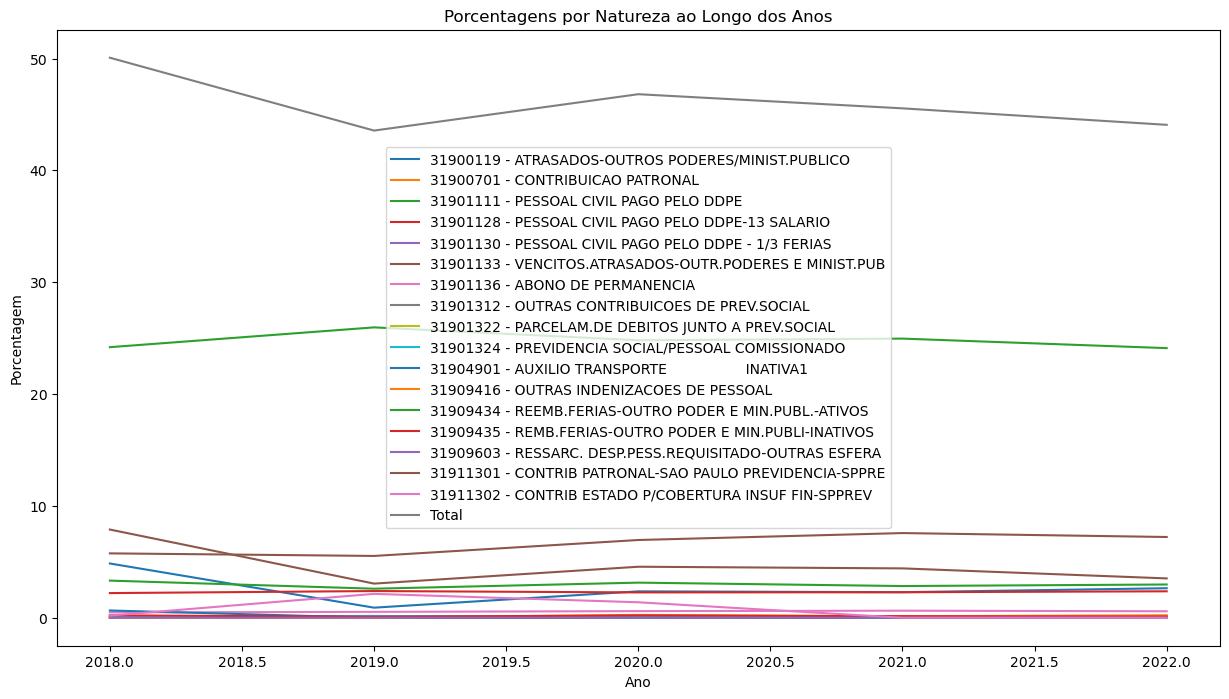

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
for coluna in df_pivotado.columns:
    plt.plot(df_pivotado.index, df_pivotado[coluna], label=coluna)

plt.title('Porcentagens por Natureza ao Longo dos Anos')
plt.xlabel('Ano')
plt.ylabel('Porcentagem')
plt.legend()
plt.show()

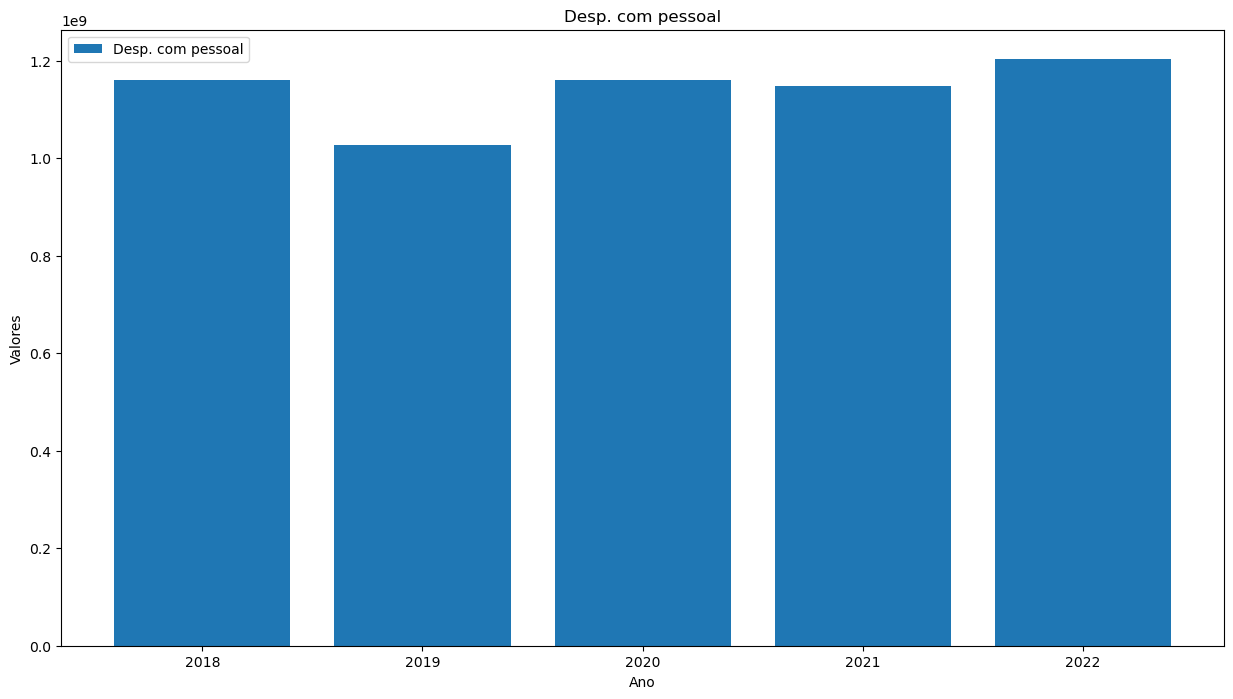

In [22]:
plt.figure(figsize=(15, 8))
plt.bar(df_pivotado_1.index, df_pivotado_1['Total'], label="Desp. com pessoal")
plt.title('Desp. com pessoal')
plt.xlabel('Ano')
plt.ylabel('Valores')
plt.legend()
plt.show()

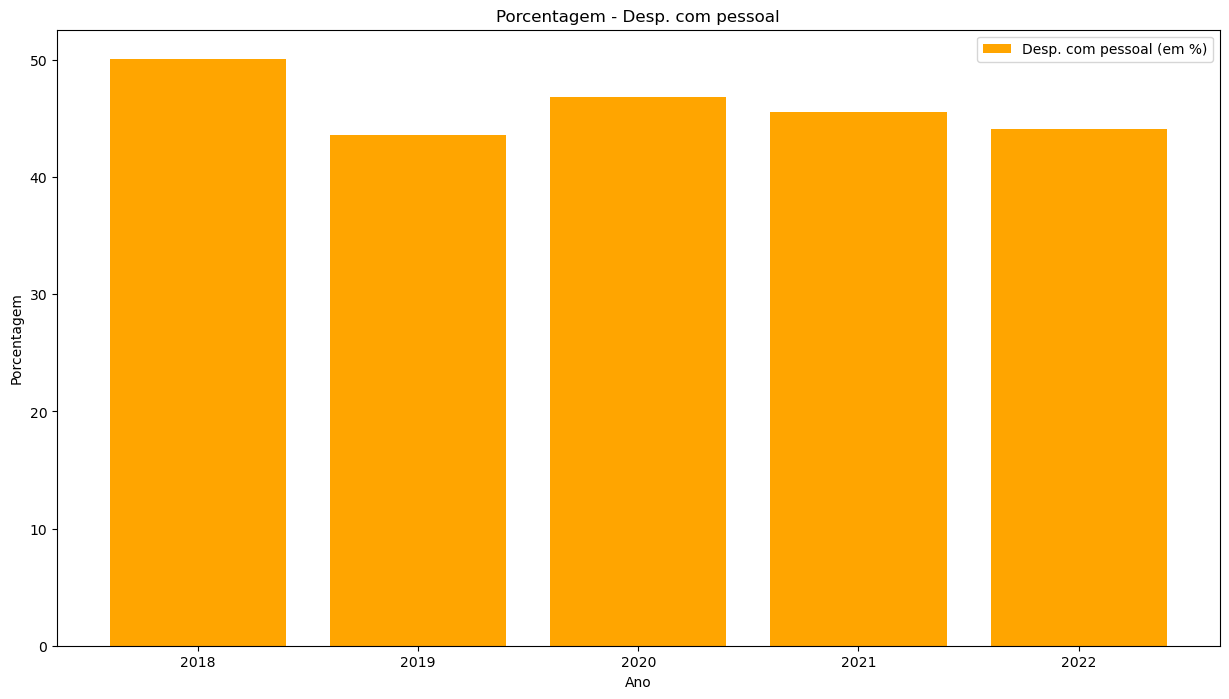

In [23]:
plt.figure(figsize=(15, 8))
plt.bar(df_pivotado.index, df_pivotado['Total'], label="Desp. com pessoal (em %)", color = 'orange')
plt.title('Porcentagem - Desp. com pessoal')
plt.xlabel('Ano')
plt.ylabel('Porcentagem')
plt.legend()
plt.show()

Consulta web:https://www.fazenda.sp.gov.br/SigeoLei131/Paginas/FlexConsDespesa.aspx

Link de acesso ao webservice da Fazenda: https://webservices.fazenda.sp.gov.br/WSTransparencia/TransparenciaServico.asmx

Manual técnico: https://portal.fazenda.sp.gov.br/acessoinformacao/Downloads/Webservice/Manual%20do%20Webservice.pdf

Conversão do XML em Dataframe baseado em: https://www.geeksforgeeks.org/convert-xml-structure-to-dataframe-using-beautifulsoup-python/

Criado em 11 jul. 2021 e atualizado em 13 nov. 2023.